In [1]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

sns.set_theme(style='white')

In [2]:
# import packages
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler

#### Setup DB connection

In [3]:
from sqlalchemy import create_engine


def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [4]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [5]:
# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

In [ ]:
# data_query = '''
# Select *
# from adds_temp.ebw_metric_analysis as ema
# '''

In [ ]:
# engine = postgresql_engine(username, password, url, port, database)
# with engine.connect() as conn:
#     with conn.begin():
#         df_ebw_metrics = pd.read_sql(data_query, con=conn)

In [6]:
# create DB engine
engine = postgresql_engine(username, password, url, port, database)

#### POP Top Quintile Check

In [ ]:
# query_top_quint_check = '''
# Select c.test_date, f.format_code, c.cmm_station_calls, c.song_id, c.pop
# from data.cmm as c, data.formats as f
# where c.project_type='Callout'
# and c.test_date >= '2019-01-01'
# and c.breakout_id=1
# and f.format_id=c.format_id
# '''
#
# with engine.connect() as conn:
#     with conn.begin():
#         df_top_quint_check = pd.read_sql(query_top_quint_check, con=conn)

In [ ]:
# # aggregate by week and station
# df_top_quint_check_agg = df_top_quint_check.groupby(['format_code', 'cmm_station_calls', 'test_date']).apply(lambda x: np.quantile(x['pop'], 0.80)).reset_index(name='top_quintile_cutoff')

In [ ]:
# with engine.connect() as conn:
#     with conn.begin():
#         df_top_quint_check_agg.to_sql(name='ebw_top_quintile_cutoff_py', con=conn, schema='adds_temp', chunksize=5000)

#### read in raw features from postgres DB

In [7]:
# read raw features table
query_raw_features = '''
Select *
from adds_temp.ebw_raw_features_h1 as eh
--where extract (year from eh.song_release_date) >= 2020
'''

with engine.connect() as conn:
    with conn.begin():
        df_raw_features = pd.read_sql(query_raw_features, con=conn)

In [ ]:
# write to pickle file
# df_raw_features.to_pickle('ebw_df_raw_features_h1.pkl')

In [ ]:
# read in pickle file
# df_raw_features = pd.read_pickle('ebw_df_raw_features_h1.pkl')

In [ ]:
# explicit cast for date related fields
date_cols = ['week_dt', 'song_release_date', 'hit_tag_date', 'first_spin_date', 'last_spin_date', 'ftq_date',
             'last_callout_date', 'first_callout_date']

df_raw_features[date_cols] = df_raw_features[date_cols].apply(pd.to_datetime)

In [11]:
df_raw_features.sort_values(by=['mediabase_id', 'call_letters', 'week_dt'], inplace=True)

In [9]:
df_raw_features.describe()

,mediabase_id,song_id,artist_id,song_release_year,burnout_flg,song_station_pop,song_station_ddl,song_station_fav,count_song_format_pop,song_format_pop,...,mean_completed_rate_prior_unv,std_completed_rate_prior_unv,med_completed_rate_prior_unv,mr_completed_rate_prior_unv,max_thumbs_up_rate_prior_unv,min_thumbs_up_rate_prior_unv,mean_thumbs_up_rate_prior_unv,std_thumbs_up_rate_prior_unv,med_thumbs_up_rate_prior_unv,mr_thumbs_up_rate_prior_unv
count,6.554830e+05,6.554830e+05,6.554830e+05,655483.000000,655483.000000,90137.000000,90137.000000,90137.000000,367586.000000,367586.000000,...,510043.000000,509985.000000,510043.000000,510043.000000,510043.000000,510043.000000,510043.000000,509985.000000,510043.000000,510043.000000
mean,2.425521e+06,5.960761e+08,1.336633e+08,2018.188742,0.657077,79.369182,16.227032,24.707357,6.189123,77.534691,...,0.581692,0.097285,0.605463,0.627662,0.932612,0.245139,0.777787,0.144706,0.813285,0.779993
std,1.406314e+05,5.306898e+08,2.323062e+08,1.303792,0.474686,8.924565,6.565467,6.662695,5.432206,7.003532,...,0.073448,0.046107,0.075289,0.108653,0.063015,0.308202,0.083212,0.097272,0.093026,0.180510
min,1.086587e+06,8.486004e+07,2.636388e+07,2017.000000,0.000000,30.000000,0.000000,0.000000,1.000000,32.000000,...,0.016603,0.000000,0.016603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.305938e+06,2.630307e+08,2.637288e+07,2017.000000,0.000000,74.000000,11.000000,20.000000,1.000000,74.000000,...,0.552742,0.063807,0.585345,0.592651,0.892806,0.000000,0.747578,0.061764,0.791103,0.759036
50%,2.393994e+06,3.633918e+08,2.648885e+07,2018.000000,1.000000,80.000000,16.000000,24.000000,4.000000,78.000000,...,0.593508,0.093491,0.614852,0.636205,0.936481,0.000000,0.790422,0.139176,0.825279,0.819379
75%,2.522450e+06,9.315509e+08,3.233308e+07,2019.000000,1.000000,86.000000,21.000000,29.000000,10.000000,82.000000,...,0.627191,0.127278,0.642290,0.683254,1.000000,0.583251,0.831043,0.195816,0.858829,0.867139
max,2.865765e+06,2.321893e+09,7.390739e+08,2022.000000,1.000000,113.000000,46.000000,58.000000,33.000000,108.000000,...,0.886957,0.353226,1.000000,1.000000,1.000000,1.000000,1.000000,0.707107,1.000000,1.000000


In [ ]:
# query_r_conv = '''
# WITH gcr_station_track AS
# (
# SELECT
#     eg.*,
#     LAG(eg.gcr, 1) OVER(PARTITION BY eg.mediabase_id,
#     eg.call_letters
# ORDER BY
#     eg.week_dt) AS gcr_plus_1,
#     LAG(eg.gcr, 2) OVER(PARTITION BY eg.mediabase_id,
#     eg.call_letters
# ORDER BY
#     eg.week_dt) AS gcr_plus_2
# FROM
#     adds_temp.ebw_gcr_tracker_h1 AS eg
#     --WHERE
#     --eg.mediabase_id = 2505085
#     --AND eg.call_letters = 'KIIS-FM'
# ORDER BY
#     call_letters,
#     mediabase_id,
#     week_dt)
# SELECT
#     gst.mediabase_id,
#     gst.call_letters,
#     gst.song_release_date,
#     extract(year from gst.song_release_date) as song_release_year,
#     gst.hit_tag_date,
#     min(gst.week_dt) AS r_conv_date,
#     CASE
#         WHEN gst.hit_tag_date < min(gst.week_dt) THEN 1
#         ELSE 0
#     END AS hit_before_flag
# FROM
#     gcr_station_track AS gst
# WHERE
#     gst.gcr = 'R'
#     AND gst.gcr_plus_1 = 'R'
#     AND gst.gcr_plus_2 = 'R'
#     and extract(year from gst.song_release_date) >= 2020
# GROUP BY
#     1,
#     2,
#     3,
#     4,
#     5
# ORDER BY
#     1,
#     2
# '''
# with engine.connect() as conn:
#     with conn.begin():
#         df_r_conv = pd.read_sql(query_r_conv, con=conn)

In [ ]:
# df_r_conv

In [ ]:
# df_r_conv.groupby(['song_release_year'])['hit_before_flag'].sum()/(df_r_conv.groupby(['song_release_year'])['hit_before_flag'].count())

#### calculated fields

In [ ]:
# Define a dictionary of computed columns to create
computed_cols = {
    'cuml_song_station_spins_non_on': lambda df: df.groupby(['mediabase_id', 'call_letters'])['song_station_spins_non_on'].cumsum(),
    'weeks_since_first_spins': lambda df: (df['week_dt'] - df['first_spin_date']) / np.timedelta64(1, 'W'),
    'weeks_since_release': lambda df: np.round((df['week_dt'] - df['song_release_date']) / np.timedelta64(1, 'W')),
    'weeks_since_hit': lambda df: (df['week_dt'] - df['hit_tag_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_top_quintiles': lambda df: (df['hit_tag_date'] - df['ftq_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_ddl_thresh_cross': lambda df: (df['ddl_over_thresh_dt_second'] - df['ddl_over_thresh_dt_first']) / np.timedelta64(1, 'W'),
    'market_spins_propn': lambda df: df['song_station_spins_non_on'] / df['song_market_spins_non_on'],
    'artist_spins_propn': lambda df: df['song_station_spins_non_on'] / df['artist_station_spins_non_on']
}

# Use assign with a dictionary comprehension to create the computed columns
df_raw_features = df_raw_features.assign(**{col_name: func(df_raw_features) for col_name, func in computed_cols.items()})

In [ ]:
# Define a sub-dataframe containing only the rows where week_dt equals hit_tag_date
mask = df_raw_features['week_dt'] == df_raw_features['hit_tag_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_hit', how='left')

In [14]:
# Define a sub-dataframe containing only the rows where week_dt equals ftq_date
mask = df_raw_features['week_dt'] == df_raw_features['ftq_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_ftq', how='left')

In [15]:
# Filter rows where week_dt equals ddl_over_thresh_dt_first
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_first']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_pre_burnout',
                                       how='left')

In [16]:
# Filter rows where week_dt equals ddl_over_thresh_dt_second
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_second']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_burnout', how='left')

In [18]:
df_raw_features['hit_spins_bucket'] = pd.cut(df_raw_features['cuml_song_station_spins_non_on_at_hit'], np.arange(0,
                                                                                                                 np.max(
                                                                                                                     df_raw_features[
                                                                                                                         'cuml_song_station_spins_non_on_at_hit']),
                                                                                                                 250))

#### feature engineering

In [19]:
pop_cols = [col for col in df_raw_features.columns if
            (('_pop' in col) or ('_ddl' in col) or ('_fav' in col)) and ('weeks_' not in col)]

In [20]:
pop_cols

['song_station_pop',
 'song_station_ddl',
 'song_station_fav',
 'count_song_format_pop',
 'song_format_pop',
 'song_format_ddl',
 'song_format_fav',
 'count_artist_format_pop',
 'artist_format_pop',
 'artist_format_ddl',
 'artist_format_fav']

In [21]:
# shift pop scores to obtain prior pop scores
df_raw_features = df_raw_features.assign(**{
    col + '_prior': df_raw_features[['mediabase_id', 'call_letters'] + [col]].groupby(
        ['mediabase_id', 'call_letters']).ffill().shift(1) for col in pop_cols})

In [22]:
df_raw_features

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,song_station_ddl_prior,song_station_fav_prior,count_song_format_pop_prior,song_format_pop_prior,song_format_ddl_prior,song_format_fav_prior,count_artist_format_pop_prior,artist_format_pop_prior,artist_format_ddl_prior,artist_format_fav_prior
0,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,1.0,87.0,5.0,30.0,1.0,87.0,5.0,30.0
2,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,6.0,77.0,10.0,26.0,6.0,77.0,10.0,26.0
3,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,6.0,77.0,10.0,26.0,6.0,77.0,10.0,26.0
4,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,13.0,80.0,10.0,25.0,13.0,80.0,10.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655478,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,12.0,29.0,14.0,89.0,9.0,30.0,17.0,86.0,9.0,28.0
655479,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,12.0,29.0,12.0,86.0,9.0,28.0,15.0,83.0,8.0,26.0
655480,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,15.0,22.0,16.0,87.0,10.0,27.0,23.0,80.0,9.0,24.0
655481,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,15.0,22.0,13.0,81.0,12.0,25.0,18.0,76.0,10.0,22.0


In [72]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
id_cols = ['mediabase_id', 'call_letters']
sel_cols = [col + '_prior' for col in pop_cols]
mask = (df_raw_features['mediabase_id'] == 1086587) & (df_raw_features['call_letters'] == 'KHTS-FM') & (
            df_raw_features['weeks_since_hit'] > 0)
mask = df_raw_features['weeks_since_hit'] > 0
df_raw_features_tst = df_raw_features.copy()
df_raw_features_tst.assign(**{'test_' + col: df_raw_features[mask].groupby(id_cols)[[col]].apply(lambda x: x.rolling(window=4, min_periods=1).mean()) for col in sel_cols})

TypeError: incompatible index of inserted column with frame index

In [62]:
df_temp = df_raw_features[mask].groupby(id_cols)[sel_cols[0]].apply(lambda x: x.rolling(window=4, min_periods=1).mean())

In [66]:
df_raw_features[mask].groupby(id_cols)[sel_cols].apply(lambda x: x.rolling(window=4, min_periods=1).mean())

song_station_pop_prior  \
mediabase_id call_letters                                  
1086587      KHTS-FM      20                   89.000000   
                          21                   89.000000   
                          22                   85.666667   
                          23                   84.000000   
                          24                   79.000000   
...                                                  ...   
2865765      WZFT-FM      655478               82.000000   
                          655479               82.000000   
                          655480               80.250000   
                          655481               78.500000   
                          655482               80.000000   

                                  song_station_ddl_prior  \
mediabase_id call_letters                                  
1086587      KHTS-FM      20                   10.000000   
                          21                   10.000000   
                          22                   13.666667   
                          23                   15.500000   
                          24                   19.500000   
...                                                  ...   
2865765      WZFT-FM      655478               10.666667   
                          655479               11.000000   
                          655480               12.250000   
                          655481               13.500000   
                          655482               12.750000   

                                  song_station_fav_prior  \
mediabase_id call_letters                                  
1086587      KHTS-FM      20                   26.000000   
                          21                   26.000000   
                          22                   26.000000   
                          23                   26.000000   
                          24                   24.000000   
...                                                  ...   
2865765      WZFT-FM      655478               26.333333   
                          655479               27.000000   
                          655480               26.250000   
                          655481               25.500000   
                          655482               23.250000   

                                  count_song_format_pop_prior  \
mediabase_id call_letters                                       
1086587      KHTS-FM      20                         3.000000   
                          21                         2.000000   
                          22                         2.000000   
                          23                         1.750000   
                          24                         1.250000   
...                                                       ...   
2865765      WZFT-FM      655478                    12.666667   
                          655479                    12.500000   
                          655480                    12.750000   
                          655481                    13.750000   
                          655482                    14.500000   

                                  song_format_pop_prior  \
mediabase_id call_letters                                 
1086587      KHTS-FM      20                  82.000000   
                          21                  82.000000   
                          22                  80.333333   
                          23                  76.500000   
                          24                  73.250000   
...                                                 ...   
2865765      WZFT-FM      655478              85.333333   
                          655479              85.500000   
                          655480              86.000000   
                          655481              85.750000   
                          655482              85.500000   

                                  song_format_ddl_prior  \
mediabase_id call_

In [61]:
df_raw_features_tst[['weeks_since_hit'] + [sel_cols[0]] + ['test_col']]

,weeks_since_hit,song_station_pop_prior,test_col
0,-19.0,NaN,NaN
1,-18.0,NaN,NaN
2,-17.0,NaN,NaN
3,-16.0,NaN,NaN
4,-15.0,NaN,NaN
...,...,...,...
655478,3.0,82.0,82.00
655479,4.0,82.0,82.00
655480,5.0,75.0,80.25
655481,6.0,75.0,78.50


In [23]:
spins_cols = [col for col in df_raw_features.columns if
              ('_spins' in col) and ('cuml_' not in col) and ('_bucket' not in col) and ('_propn' not in col) and (
                      'weeks_' not in col)]

In [25]:
spins_cols

['song_station_spins_total',
 'song_station_spins_non_on',
 'song_station_spins_am_pm_dr',
 'song_format_spins_total',
 'song_format_spins_non_on',
 'song_format_spins_am_pm_dr',
 'song_market_spins_total',
 'song_market_spins_non_on',
 'song_market_spins_am_pm_dr',
 'artist_station_spins_total',
 'artist_station_spins_non_on',
 'artist_station_spins_am_pm_dr',
 'artist_format_spins_total',
 'artist_format_spins_non_on',
 'artist_format_spins_am_pm_dr',
 'artist_market_spins_total',
 'artist_market_spins_non_on',
 'artist_market_spins_am_pm_dr']

In [26]:
# shift spins to obtain prior pop scores
df_raw_features = df_raw_features.assign(**{
    col + '_prior': df_raw_features[['mediabase_id', 'call_letters'] + [col]].groupby(
        ['mediabase_id', 'call_letters']).shift(1) for col in spins_cols})

In [27]:
df_raw_features

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,song_market_spins_am_pm_dr_prior,artist_station_spins_total_prior,artist_station_spins_non_on_prior,artist_station_spins_am_pm_dr_prior,artist_format_spins_total_prior,artist_format_spins_non_on_prior,artist_format_spins_am_pm_dr_prior,artist_market_spins_total_prior,artist_market_spins_non_on_prior,artist_market_spins_am_pm_dr_prior
0,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,22.0,17.0,11.0,5.0,1329.0,1005.0,672.0,68.0,45.0,22.0
2,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,29.0,30.0,16.0,5.0,4103.0,2981.0,1894.0,96.0,62.0,31.0
3,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,35.0,29.0,19.0,6.0,6347.0,4564.0,3044.0,105.0,72.0,41.0
4,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,50.0,37.0,31.0,17.0,8134.0,5905.0,4041.0,121.0,94.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655478,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,71.0,171.0,121.0,83.0,24908.0,17706.0,11922.0,275.0,181.0,128.0
655479,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,84.0,215.0,159.0,113.0,27498.0,19625.0,13243.0,338.0,233.0,165.0
655480,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,100.0,205.0,151.0,110.0,30006.0,21590.0,14580.0,343.0,231.0,167.0
655481,2865765,2321893248,WZFT-FM,Baltimore,28054077,H1,2022-12-01,2023-01-30,2023-04-03,2023-01-01,...,89.0,183.0,135.0,100.0,29890.0,21529.0,14716.0,319.0,214.0,154.0


In [28]:
stream_cols = [col for col in df_raw_features.columns if '_unv' in col]

In [29]:
stream_cols

['max_stream_count_prior_unv',
 'min_stream_count_prior_unv',
 'mean_stream_count_prior_unv',
 'std_stream_count_prior_unv',
 'med_stream_count_prior_unv',
 'mr_stream_count_prior_unv',
 'max_completed_count_prior_unv',
 'min_completed_count_prior_unv',
 'mean_completed_count_prior_unv',
 'std_completed_count_prior_unv',
 'med_completed_count_prior_unv',
 'mr_completed_count_prior_unv',
 'max_completed_rate_prior_unv',
 'min_completed_rate_prior_unv',
 'mean_completed_rate_prior_unv',
 'std_completed_rate_prior_unv',
 'med_completed_rate_prior_unv',
 'mr_completed_rate_prior_unv',
 'max_thumbs_up_rate_prior_unv',
 'min_thumbs_up_rate_prior_unv',
 'mean_thumbs_up_rate_prior_unv',
 'std_thumbs_up_rate_prior_unv',
 'med_thumbs_up_rate_prior_unv',
 'mr_thumbs_up_rate_prior_unv']

In [136]:
# shift streams to obtain prior streams
df_raw_features = df_raw_features.assign(**{
    col + '_prior': df_raw_features[['mediabase_id', 'call_letters'] + [col]].groupby(
        ['mediabase_id', 'call_letters']).ffill().shift(1) for col in stream_cols})

In [137]:
propn_cols = [col for col in df_raw_features.columns if 'propn' in col]

In [138]:
propn_cols

['market_spins_propn', 'artist_spins_propn']

In [139]:
df_raw_features = df_raw_features.assign(**{
    col + '_prior': df_raw_features[['mediabase_id', 'call_letters'] + [col]].groupby(
        ['mediabase_id', 'call_letters']).shift(1) for col in propn_cols})

In [148]:
df_raw_features['spins_to_burnout'] = df_raw_features['cuml_song_station_spins_non_on_at_burnout'] - df_raw_features[
    'cuml_song_station_spins_non_on']

#### Abnormal Hit Instances

In [ ]:
query_abnormal_check = '''
-- censoring and abnormal instances
SELECT
    sv.song_name || '(' || sv.artist_name || ')' AS song_artist,
    EXTRACT(YEAR
FROM
    eh.song_release_date) AS song_release_year,
    eh.*,
    eft.ftq_date,
    ed.ddl_over_thresh_dt_first,
    ed.ddl_over_thresh_dt_second,
    edf.ddl_over_thresh_dt_first_unf,
    edf.ddl_over_thresh_dt_second_unf
FROM
    adds_temp.ebw_hits_tracker_h1 AS eh
LEFT JOIN data.songs_v AS sv
ON
    sv.mediabase_id = eh.mediabase_id
LEFT JOIN adds_temp.ebw_hits_ftq_h1 as eft
on eft.mediabase_id = eh.mediabase_id
and eft.call_letters = eh.call_letters
LEFT JOIN data.stations_v AS st
ON
    st.call_letters = eh.call_letters
LEFT JOIN
    adds_temp.ebw_ddl_tracker_h1 AS ed
ON
    ed.mediabase_id = eh.mediabase_id
    AND ed.call_letters = eh.call_letters
LEFT JOIN adds_temp.ebw_ddl_tracker_unf_h1 AS edf
ON
    edf.mediabase_id = eh.mediabase_id
    AND edf.call_letters = eh.call_letters
ORDER BY
    3,
    1,
    2
'''
with engine.connect() as conn:
    with conn.begin():
        df_abnorm_checks = pd.read_sql(query_abnormal_check, conn)

In [ ]:
df_abnorm_checks['hit_tag_date'] = pd.to_datetime(df_abnorm_checks['hit_tag_date'])

In [ ]:
list(df_raw_features.columns[-13:])

In [ ]:
# setup columns for join with raw features data frame
index_cols = ['mediabase_id', 'call_letters', 'week_dt']
join_cols = ['mediabase_id', 'call_letters', 'hit_tag_date']
sel_cols = ['weeks_bw_top_quintiles',
            'weeks_bw_ddl_thresh_cross',
            'market_spins_propn',
            'artist_spins_propn',
            'week_dt_at_hit',
            'cuml_song_station_spins_non_on_at_hit',
            'week_dt_at_ftq',
            'cuml_song_station_spins_non_on_at_ftq',
            'week_dt_at_pre_burnout',
            'cuml_song_station_spins_non_on_at_pre_burnout',
            'week_dt_at_burnout',
            'cuml_song_station_spins_non_on_at_burnout',
            'hit_spins_bucket']

In [ ]:
df_abnorm_checks = df_abnorm_checks.join(df_raw_features.set_index(index_cols)[sel_cols], on=join_cols, how='left')

In [ ]:
df_abnorm_checks

In [ ]:
# calculated columns
df_abnorm_checks = df_abnorm_checks.assign(
    **{'weeks_to_burnout': (df_abnorm_checks['ddl_over_thresh_dt_second'] - df_abnorm_checks[
        'first_spin_date']) / np.timedelta64(1, 'W'),
       'spins_to_burnout_from_hit': df_abnorm_checks['cuml_song_station_spins_non_on_at_burnout'] - df_abnorm_checks[
           'cuml_song_station_spins_non_on_at_hit'],
       'no_burnout_flg': pd.isna(df_abnorm_checks['ddl_over_thresh_dt_second']).apply(int),
       'premature_burnout_flg':
           (df_abnorm_checks['ddl_over_thresh_dt_second_unf'] < df_abnorm_checks[
               'hit_tag_date']).apply(int),
       'spins_stoppage_flg':
           (df_abnorm_checks['last_spin_date'] < df_abnorm_checks[
               'ddl_over_thresh_dt_second']).apply(int),
       'callout_stoppage_flg':
           (df_abnorm_checks['last_callout_date'] < df_abnorm_checks[
               'ddl_over_thresh_dt_second']).apply(int)

       })

In [ ]:
df_abnorm_checks

In [ ]:
from scipy import stats

# identify outliers based on z scores
df_abnorm_checks = df_abnorm_checks.assign(
    **{'burnout_time_outlier': (np.abs(np.nan_to_num(
        stats.zscore(df_abnorm_checks['cuml_song_station_spins_non_on_at_burnout'], nan_policy='omit'))) >= 2.3),
       'spins_to_burnout_from_hit_outlier': (np.abs(
           np.nan_to_num(stats.zscore(df_abnorm_checks['spins_to_burnout_from_hit'], nan_policy='omit'))) >= 2.3),
       'weeks_between_top_quints_outlier': (
               np.abs(
                   np.nan_to_num(stats.zscore(df_abnorm_checks['weeks_bw_top_quintiles'], nan_policy='omit'))) >= 2.3)})

In [ ]:
# Examine burnout outliers - delayed burn
mask = (df_abnorm_checks['burnout_time_outlier'])
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

In [ ]:
df_abnorm_checks[mask][['song_artist', 'call_letters', 'song_release_date', 'hit_tag_date', 'ddl_over_thresh_dt_second',
                        'cuml_song_station_spins_non_on_at_burnout']]

In [ ]:
# Examine top quints separation outliers
mask = df_abnorm_checks['weeks_between_top_quints_outlier']
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

In [ ]:
df_abnorm_checks[mask][['song_artist', 'call_letters', 'song_release_date', 'ftq_date', 'hit_tag_date',
                        'weeks_bw_top_quintiles']].sort_values(by=['weeks_bw_top_quintiles'], ascending=False)

In [ ]:
# No burnout
mask = df_abnorm_checks['no_burnout_flg'].astype(bool)
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

In [ ]:
df_abnorm_checks[mask][
    ['song_artist', 'call_letters', 'song_release_date', 'ftq_date', 'hit_tag_date', 'ddl_over_thresh_dt_first',
     'ddl_over_thresh_dt_second']]

In [ ]:
# premature burnout
mask = df_abnorm_checks['premature_burnout_flg'].astype(bool)
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

In [ ]:
df_abnorm_checks[mask][
    ['song_artist', 'call_letters', 'song_release_date', 'ftq_date', 'hit_tag_date', 'last_spin_date',
     'ddl_over_thresh_dt_first', 'ddl_over_thresh_dt_second', 'ddl_over_thresh_dt_first_unf',
     'ddl_over_thresh_dt_second_unf']].sort_values(by=['call_letters'])

In [ ]:
# spin stoppage
mask = df_abnorm_checks['spins_stoppage_flg'].astype(bool)
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

In [ ]:
df_abnorm_checks[mask][
    ['song_artist', 'call_letters', 'song_release_date', 'ftq_date', 'hit_tag_date', 'last_spin_date',
     'ddl_over_thresh_dt_first', 'ddl_over_thresh_dt_second']]

In [ ]:
# callout stoppage
mask = df_abnorm_checks['callout_stoppage_flg'].astype(bool)
df_abnorm_checks[mask].groupby(['song_release_year'])['mediabase_id'].count()

#### burnout Comparison by song_release_date

In [ ]:
sel_cols = ['weeks_to_burnout', 'no_burnout_flg', 'song_release_year', 'song_release_date']
df_burn_comparison = df_abnorm_checks[sel_cols]

In [ ]:
df_abnorm_checks

In [ ]:
df_burn_comparison['burnout_flg'] = (1 - df_burn_comparison['no_burnout_flg']).astype(bool) & (
            df_burn_comparison['weeks_to_burnout'] <= 104)

In [ ]:
df_burn_comparison

In [ ]:
df_burn_comparison['song_release_quarter'] = pd.to_datetime(df_burn_comparison['song_release_date']).dt.to_period(
    'Q').apply(lambda x: str(x)[-2:])

In [ ]:
df_burn_comparison.groupby(['song_release_year', 'song_release_quarter'])['burnout_flg'].sum() /
df_burn_comparison.groupby(['song_release_year', 'song_release_quarter'])['burnout_flg'].count()

In [ ]:
df_burn_comparison

In [ ]:
df_burn_comparison['weeks_to_burnout'].dropna().plot(kind='box')

In [ ]:
df_burn_comparison.groupby(['song_release_year'])['burnout_flg'].sum() /
df_burn_comparison.groupby(['song_release_year'])['burnout_flg'].count()

In [ ]:
1 - df_burn_comparison.groupby(['song_release_year'])['no_burnout_flg'].sum() /
df_burn_comparison.groupby(['song_release_year'])['no_burnout_flg'].count()

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

for treatment_type in pd.unique(df_burn_comparison['song_release_year']):
    if treatment_type < 2022:
        mask_treat = df_burn_comparison["song_release_year"] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            df_burn_comparison["burnout_flg"][mask_treat],
            df_burn_comparison["weeks_to_burnout"][mask_treat].fillna(300))

        plt.step(time_treatment, 100 * survival_prob_treatment, where="post",
                 label="%s" % int(treatment_type))

plt.xlim([0, 104])
plt.ylabel("probability of survival(no burnout) (%)")
plt.xlabel("weeks since first spins")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.savefig('burnout_by_year.jpeg', format='jpeg', dpi=300)

In [ ]:
df_burn_comparison['weeks_to_burnout'].fillna(104, inplace=True)

In [ ]:
from sksurv.compare import compare_survival

mask = (df_burn_comparison['song_release_year'] >= 2017) & (df_burn_comparison['song_release_year'] <= 2021)
y_cols = ['burnout_flg', 'weeks_to_burnout']
chisq, pvalue, stats, covariance = compare_survival(df_burn_comparison[mask][y_cols].to_records(index=False),
                                                    group_indicator=df_burn_comparison[mask]['song_release_year'],
                                                    return_stats=True)

In [ ]:
pvalue

In [ ]:
stats['burn_perc'] = stats['observed'] / stats['counts']

In [ ]:
stats

In [ ]:
df_abnorm_checks['spins_to_burnout_from_hit'].plot(kind='hist')

In [ ]:
df_abnorm_checks.groupby(['hit_spins_bucket'])['spins_to_burnout_from_hit'].describe()

In [ ]:
plt.scatter(df_abnorm_checks['hit_spins_bucket'], df_abnorm_checks['spins_to_burnout_from_hit'])

In [128]:
mask = df_abnorm_checks['spins_to_burnout_from_hit_outlier']
df_abnorm_checks[mask][
    ['song_artist', 'call_letters', 'market_name', 'song_release_date', 'cuml_song_station_spins_non_on_at_hit',
     'cuml_song_station_spins_non_on_at_pre_burnout',
     'cuml_song_station_spins_non_on_at_burnout', 'spins_to_burnout_from_hit']]

,song_artist,call_letters,market_name,song_release_date,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_pre_burnout,cuml_song_station_spins_non_on_at_burnout,spins_to_burnout_from_hit
87,Issues(JULIA MICHAELS),KZZP-FM,Phoenix,2017-01-01,535.0,2884.0,2949.0,2414.0
552,New Rules(DUA LIPA),WIHT-FM,"Washington, DC",2017-06-01,519.0,2585.0,2827.0,2308.0
730,Rockstar f/21 Savage(POST MALONE),KHKS-FM,Dallas,2017-09-01,390.0,2775.0,2802.0,2412.0
774,Truth Hurts(LIZZO),KSLZ-FM,St. Louis,2017-09-01,378.0,2566.0,2654.0,2276.0
1028,Love Lies(KHALID X NORMANI),KIIS-FM,Los Angeles,2018-03-01,588.0,1696.0,2858.0,2270.0
1042,Love Lies(KHALID X NORMANI),WKQI-FM,Detroit,2018-03-01,427.0,1582.0,3154.0,2727.0
1236,Trampoline(SHAED),WKSC-FM,Chicago,2018-09-01,363.0,2602.0,2621.0,2258.0
1272,High Hopes(PANIC! AT THE DISCO),WNCI-FM,"Columbus, OH",2018-05-01,561.0,2514.0,2869.0,2308.0
1298,"Eastside(BENNY BLANCO, HALSEY & KHALID)",KBKS-FM,Seattle,2018-07-01,1246.0,3043.0,4403.0,3157.0
1605,Dancing With A Stranger(SAM SMITH & NORMANI),KIIS-FM,Los Angeles,2019-01-01,467.0,3374.0,3562.0,3095.0


#### EDA

In [ ]:
feature_cols = ['cuml_song_station_spins_non_on_at_pre_burnout', 'cuml_song_station_spins_non_on_at_ftq',
                'weeks_bw_top_quintiles', 'cuml_song_station_spins_non_on_at_hit',
                ]
target = ['cuml_song_station_spins_non_on_at_burnout']
id_cols = ['mediabase_id', 'call_letters']

In [ ]:
df_eda = df_raw_features[id_cols + feature_cols + target].drop_duplicates().dropna()

In [ ]:
df_eda.columns = ['mediabase_id', 'call_letters',
                  'spins_at_pre_burnout',
                  'spins_at_ftq', 'weeks_bw_top_quintiles',
                  'spins_at_hit',
                  'spins_at_burnout']

In [ ]:
df_eda

In [ ]:
ax = sns.pairplot(df_eda[list(set(df_eda.columns) - set(id_cols))])
sns.set_context("paper", rc={"xtick.labelsize": 18, "xtick.rotation": 45})

In [ ]:
df_raw_features.groupby(['hit_spins_bucket', 'burnout_flg']).agg({'mediabase_id': lambda x: len(pd.unique(x))})

In [ ]:
df_raw_features['weeks_bw_ddl_thresh_cross'].plot(kind='hist', bins=np.arange(0, 210, 5))

In [ ]:
(df_raw_features[['mediabase_id', 'song_release_year', 'cuml_song_station_spins_non_on_at_hit',
                  'cuml_song_station_spins_non_on_at_ftq']].drop_duplicates()).groupby(['song_release_year']).apply(
    lambda x: x['cuml_song_station_spins_non_on_at_hit'] - x['cuml_song_station_spins_non_on_at_ftq']).describe()

In [ ]:
(df_raw_features[['mediabase_id', 'call_letters', 'song_release_year', 'cuml_song_station_spins_non_on_at_hit',
                  'cuml_song_station_spins_non_on_at_ftq']].drop_duplicates()).groupby(['song_release_year']).apply(
    lambda x: x['cuml_song_station_spins_non_on_at_hit'] - x[
        'cuml_song_station_spins_non_on_at_ftq']).reset_index().drop(columns=['level_1']).groupby(
    ['song_release_year'])[0].describe()

In [ ]:
df_abnorm_checks = df_abnorm_checks.join(df_burn_comparison[['burnout_flg']])

In [ ]:
df_raw_features = df_raw_features.join(df_abnorm_checks.set_index(['mediabase_id', 'call_letters'])['burnout_flg'],
                                       on=['mediabase_id', 'call_letters'], rsuffix='_r')

In [ ]:
df_raw_features

In [ ]:
agg_dict = {col + '_prior': [np.min, np.mean, np.max, np.std] for col in pop_cols + spins_cols + stream_cols}

#### add burnout flag (with censoring)

In [140]:
# correct burnout flag
df_raw_features['burnout_flg_r'] = ((df_raw_features['cuml_song_station_spins_non_on_at_burnout'] - df_raw_features[
    'cuml_song_station_spins_non_on_at_hit']) < 2500) & (~pd.isna(df_raw_features['ddl_over_thresh_dt_second']))

#### prep training and test data

In [141]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
target_cols = ['burnout_flg_r', 'spins_to_burnout']

In [142]:
feature_cols = [col + '_prior' for col in spins_cols + pop_cols + propn_cols]

In [143]:
feature_cols = list(set(feature_cols).intersection(df_raw_features.columns))

In [144]:
feature_cols = feature_cols + ['market_name']

In [145]:
feature_cols

['artist_format_spins_am_pm_dr_prior',
 'market_spins_propn_prior',
 'song_format_spins_am_pm_dr_prior',
 'artist_market_spins_total_prior',
 'artist_station_spins_total_prior',
 'song_station_spins_total_prior',
 'artist_market_spins_am_pm_dr_prior',
 'song_format_pop_prior',
 'song_station_ddl_prior',
 'song_format_spins_non_on_prior',
 'song_station_fav_prior',
 'count_song_format_pop_prior',
 'song_format_ddl_prior',
 'song_station_spins_non_on_prior',
 'song_station_spins_am_pm_dr_prior',
 'song_station_pop_prior',
 'weeks_since_first_spins_prior',
 'artist_station_spins_non_on_prior',
 'count_artist_format_pop_prior',
 'artist_format_pop_prior',
 'song_format_spins_total_prior',
 'song_market_spins_non_on_prior',
 'song_market_spins_total_prior',
 'song_market_spins_am_pm_dr_prior',
 'artist_station_spins_am_pm_dr_prior',
 'artist_format_ddl_prior',
 'artist_spins_propn_prior',
 'song_format_fav_prior',
 'artist_market_spins_non_on_prior',
 'artist_format_fav_prior',
 'artist_for

In [ ]:
# feature_cols = list(set(feature_cols) - set(['cuml_song_station_spins_non_on_at_pre_burnout_prior']))

In [146]:
df_raw_features[feature_cols]

,artist_format_spins_am_pm_dr_prior,market_spins_propn_prior,song_format_spins_am_pm_dr_prior,artist_market_spins_total_prior,artist_station_spins_total_prior,song_station_spins_total_prior,artist_market_spins_am_pm_dr_prior,song_format_pop_prior,song_station_ddl_prior,song_format_spins_non_on_prior,...,song_market_spins_am_pm_dr_prior,artist_station_spins_am_pm_dr_prior,artist_format_ddl_prior,artist_spins_propn_prior,song_format_fav_prior,artist_market_spins_non_on_prior,artist_format_fav_prior,artist_format_spins_total_prior,artist_format_spins_non_on_prior,market_name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,San Diego
1,672.0,0.250000,672.0,68.0,17.0,17.0,22.0,87.0,NaN,1005.0,...,22.0,5.0,5.0,1.000000,30.0,45.0,30.0,1329.0,1005.0,San Diego
2,1894.0,0.266667,1894.0,96.0,30.0,30.0,31.0,77.0,NaN,2981.0,...,29.0,5.0,10.0,1.000000,26.0,62.0,26.0,4103.0,2981.0,San Diego
3,3044.0,0.292308,3044.0,105.0,29.0,29.0,41.0,77.0,NaN,4564.0,...,35.0,6.0,10.0,1.000000,26.0,72.0,26.0,6347.0,4564.0,San Diego
4,4041.0,0.356322,4041.0,121.0,37.0,37.0,57.0,80.0,NaN,5905.0,...,50.0,17.0,10.0,1.000000,25.0,94.0,25.0,8134.0,5905.0,San Diego
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655478,11922.0,0.800000,9005.0,275.0,171.0,108.0,128.0,89.0,12.0,12958.0,...,71.0,83.0,9.0,0.661157,30.0,181.0,28.0,24908.0,17706.0,Baltimore
655479,13243.0,0.784483,10182.0,338.0,215.0,121.0,165.0,86.0,12.0,14703.0,...,84.0,113.0,8.0,0.572327,28.0,233.0,26.0,27498.0,19625.0,Baltimore
655480,14580.0,0.723881,11771.0,343.0,205.0,129.0,167.0,87.0,15.0,16865.0,...,100.0,110.0,9.0,0.642384,27.0,231.0,24.0,30006.0,21590.0,Baltimore
655481,14716.0,0.745902,11860.0,319.0,183.0,121.0,154.0,81.0,15.0,16857.0,...,89.0,100.0,10.0,0.674074,25.0,214.0,22.0,29890.0,21529.0,Baltimore


In [151]:
# separate train data
mask_train = (df_raw_features['song_release_year'] > 2019) & (df_raw_features['song_release_year'] < 2022) & (
            df_raw_features['weeks_since_hit'] > 0) & (df_raw_features['spins_to_burnout'].fillna(2500) > 0)
df_raw_features_train = df_raw_features[mask_train][id_cols + target_cols + feature_cols]

In [150]:
df_raw_features_train.groupby(['weeks_since_hit'])['mediabase_id'].count()

weeks_since_hit
1.0      888
2.0      876
3.0      872
4.0      850
5.0      837
        ... 
146.0      2
147.0      2
148.0      2
149.0      1
150.0      1
Name: mediabase_id, Length: 150, dtype: int64

In [152]:
# separate test data
mask_test = (df_raw_features['song_release_year'] >= 2022) & (df_raw_features['weeks_since_hit'] > 0)
df_raw_features_test = df_raw_features[mask_test][id_cols + target_cols + feature_cols]

In [153]:
df_raw_features_test

,mediabase_id,call_letters,week_dt,weeks_since_hit,burnout_flg_r,spins_to_burnout,artist_format_spins_am_pm_dr_prior,market_spins_propn_prior,song_format_spins_am_pm_dr_prior,artist_market_spins_total_prior,...,song_market_spins_am_pm_dr_prior,artist_station_spins_am_pm_dr_prior,artist_format_ddl_prior,artist_spins_propn_prior,song_format_fav_prior,artist_market_spins_non_on_prior,artist_format_fav_prior,artist_format_spins_total_prior,artist_format_spins_non_on_prior,market_name
20,1086587,KHTS-FM,2022-10-30,1.0,True,146.0,1526.0,0.617284,1526.0,108.0,...,61.0,38.0,15.0,1.000000,26.0,83.0,26.0,2783.0,2070.0,San Diego
21,1086587,KHTS-FM,2022-11-06,2.0,True,96.0,1440.0,0.635135,1440.0,98.0,...,53.0,33.0,18.0,1.000000,29.0,74.0,29.0,2607.0,1994.0,San Diego
22,1086587,KHTS-FM,2022-11-13,3.0,True,45.0,1107.0,0.581395,1107.0,114.0,...,68.0,37.0,21.0,1.000000,23.0,87.0,23.0,2168.0,1618.0,San Diego
23,1086587,KHTS-FM,2022-11-20,4.0,True,0.0,553.0,0.573034,553.0,110.0,...,72.0,38.0,29.0,1.000000,24.0,90.0,24.0,950.0,745.0,San Diego
24,1086587,KHTS-FM,2022-11-27,5.0,True,-35.0,444.0,0.500000,444.0,113.0,...,68.0,34.0,26.0,1.000000,18.0,90.0,18.0,817.0,638.0,San Diego
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655478,2865765,WZFT-FM,2023-02-26,3.0,False,NaN,11922.0,0.800000,9005.0,275.0,...,71.0,83.0,9.0,0.661157,30.0,181.0,28.0,24908.0,17706.0,Baltimore
655479,2865765,WZFT-FM,2023-03-05,4.0,False,NaN,13243.0,0.784483,10182.0,338.0,...,84.0,113.0,8.0,0.572327,28.0,233.0,26.0,27498.0,19625.0,Baltimore
655480,2865765,WZFT-FM,2023-03-12,5.0,False,NaN,14580.0,0.723881,11771.0,343.0,...,100.0,110.0,9.0,0.642384,27.0,231.0,24.0,30006.0,21590.0,Baltimore
655481,2865765,WZFT-FM,2023-03-19,6.0,False,NaN,14716.0,0.745902,11860.0,319.0,...,89.0,100.0,10.0,0.674074,25.0,214.0,22.0,29890.0,21529.0,Baltimore


#### create baseline sequence of models for each week_since_hit

In [ ]:
# import matplotlib.pyplot as plt
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [205]:
weeks_since_hit_vals = list(np.arange(1, 52, 1))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(100 * (np.abs(y_true - y_pred) / y_true))

In [158]:
mask_subset = (df_raw_features_train['weeks_since_hit'] == 1)
df_subset = df_raw_features_train[mask_subset]
df_subset['spins_to_burnout'].fillna(2500, inplace=True)

In [159]:
X_train = pd.get_dummies(df_subset[feature_cols], columns=['market_name'])

In [161]:
from scipy import integrate

In [162]:
from sklearn.model_selection import GridSearchCV

In [206]:
surv_times = pd.DataFrame()
surv_scores = pd.DataFrame()
best_estimators = {}
for val in weeks_since_hit_vals:
    mask_subset = (df_raw_features_train['weeks_since_hit'] == int(val))
    df_subset = df_raw_features_train[mask_subset]
    df_subset['spins_to_burnout'].fillna(2500, inplace=True)
    df_subset = df_subset.dropna()
    X_train = pd.get_dummies(df_subset[feature_cols], columns=['market_name'])
    y_train = df_subset[target_cols].to_records(index=False)

    # print(pd.DataFrame(X_train.isna().any()))

    X_num_cols = list(set(X_train.columns) - set(['market_name']))
    scaler = StandardScaler()
    scaler_fit = scaler.fit(X_train[X_num_cols])
    X_train[X_num_cols] = scaler.fit_transform(X_train[X_num_cols])

    coxnet = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    distributions = {'l1_ratio': [0.1, 0.5, 0.9], 'alpha_min_ratio': [0.5, 0.1, 0.01]}
    clf = GridSearchCV(coxnet, distributions)
    search = clf.fit(X_train, y_train)
    cox_elastic_net = search.best_estimator_
    best_estimators['val'] = search.best_estimator_

    #cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, fit_baseline_model=True)
    cox_elastic_net.fit(X_train, y_train)
    print('Weeks since hit: ' + str(val))
    print(cox_elastic_net.score(X_train, y_train))
    print(search.best_params_)

    surv_scores_temp = pd.DataFrame(cox_elastic_net.predict(X_train),
                                    index=df_subset.index, columns=['risk_score']).assign(
        **{i: df_subset[i] for i in id_cols + target_cols})
    surv_scores_temp['weeks_since_hit_val'] = val
    surv_scores = pd.concat([surv_scores_temp, surv_scores])

    surv_fn = cox_elastic_net.predict_survival_function(X_train)
    surv_times_temp = pd.DataFrame([integrate.simps(surv_fn[i].y, surv_fn[i].x) for i in range(len(surv_fn))],
                                   index=df_subset.index, columns=['expected_spins_to_burnout']).assign(
        **{i: df_subset[i] for i in id_cols + target_cols})
    surv_times_temp['weeks_since_hit_val'] = val
    surv_times = pd.concat([surv_times_temp, surv_times])
    # print([i for i in surv_times[val] if i < 20])
    # print(mean_absolute_error(df_subset['spins_to_burnout'], surv_times[val]))
    # print(mean_absolute_percentage_error(df_subset['spins_to_burnout'], surv_times[val]))

#
#     coefficients_elastic_net = pd.DataFrame(
#     cox_elastic_net.coef_,
#     index=X_train.columns,
#     columns=np.round(cox_elastic_net.alphas_, 5)
# )
#
#     plot_coefficients(coefficients_elastic_net, n_highlight=10)

Weeks since hit: 1
0.7044377090983575
{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}
Weeks since hit: 2
0.6917466479851908
{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}
Weeks since hit: 3
0.714081532521279
{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}
Weeks since hit: 4
0.7021679014922259
{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}
Weeks since hit: 5
0.703920447346704
{'alpha_min_ratio': 0.1, 'l1_ratio': 0.9}
Weeks since hit: 6
0.7162286166173036
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 7
0.7063030293382575
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 8
0.709144999416249
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 9
0.7067054441182743
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.5}
Weeks since hit: 10
0.717783445871691
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 11
0.72238138767502
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 12
0.725646705600205
{'alpha_min_ratio': 0.01, 'l1_ratio': 0.1}
Weeks since hit: 13
0.721022574251956

In [207]:
surv_scores[(surv_scores['weeks_since_hit'] == 51) & (surv_scores['burnout_flg_r'])].sort_values(
    by=['spins_to_burnout'])

,risk_score,mediabase_id,call_letters,week_dt,weeks_since_hit,burnout_flg_r,spins_to_burnout,weeks_since_hit_val
568088,-0.125873,2591406,WIOQ-FM,2022-10-09,51.0,True,1.0,51
616094,0.930520,2693277,WHTZ-FM,2022-05-29,51.0,True,31.0,51
605677,-0.093110,2671521,WHQC-FM,2022-09-11,51.0,True,34.0,51
575789,1.050806,2605093,WHTZ-FM,2022-10-23,51.0,True,38.0,51
561906,0.335174,2583267,WHTZ-FM,2021-07-11,51.0,True,74.0,51
560501,0.066913,2583267,KDWB-FM,2021-10-31,51.0,True,89.0,51
567521,0.081844,2591406,WFLZ-FM,2022-05-01,51.0,True,113.0,51
551061,-0.180651,2570716,KBKS-FM,2022-01-09,51.0,True,130.0,51
551965,-0.154609,2570716,WKST-FM,2022-05-22,51.0,True,140.0,51
560960,0.123049,2583267,KIIS-FM,2021-07-18,51.0,True,157.0,51


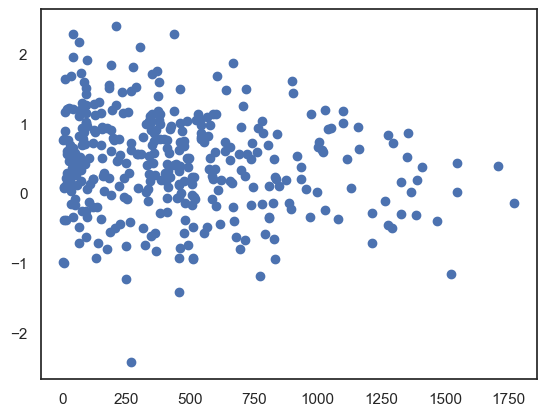

In [212]:
df_extract = surv_scores[(surv_scores['weeks_since_hit'] == 12) & (surv_scores['burnout_flg_r'])]
plt.scatter(df_extract['spins_to_burnout'], df_extract['risk_score'])

In [ ]:
surv_times

In [179]:
surv_times = surv_times.join(df_abnorm_checks.set_index(['mediabase_id', 'call_letters'])['song_artist'],
                             on=['mediabase_id', 'call_letters'])

In [180]:
new_col_order = list(surv_times.columns[1:]) + list(surv_times.columns[0:1])

In [181]:
surv_times = surv_times[new_col_order]

In [182]:
surv_times.sort_values(by=['mediabase_id', 'call_letters', 'weeks_since_hit_val'], inplace=True)

In [173]:
surv_times

,mediabase_id,call_letters,week_dt,weeks_since_hit,burnout_flg_r,spins_to_burnout,weeks_since_hit_val,song_artist,expected_spins_to_burnout
548592,2565309,WFLZ-FM,2020-11-01,1.0,True,1213.0,1,What's Poppin(JACK HARLOW),1550.791718
548593,2565309,WFLZ-FM,2020-11-08,2.0,True,1121.0,2,What's Poppin(JACK HARLOW),1740.848967
548594,2565309,WFLZ-FM,2020-11-15,3.0,True,1030.0,3,What's Poppin(JACK HARLOW),2056.389344
548758,2565309,WKQI-FM,2021-02-07,1.0,True,280.0,1,What's Poppin(JACK HARLOW),1080.596786
548759,2565309,WKQI-FM,2021-02-14,2.0,True,245.0,2,What's Poppin(JACK HARLOW),1584.856300
...,...,...,...,...,...,...,...,...,...
647716,2768404,WKFS-FM,2022-10-09,2.0,True,439.0,2,Sunroof f/Dazy(NICKY YOURE),741.002174
647717,2768404,WKFS-FM,2022-10-16,3.0,True,375.0,3,Sunroof f/Dazy(NICKY YOURE),1278.265704
647775,2768404,WKQI-FM,2023-01-08,1.0,False,2500.0,1,Sunroof f/Dazy(NICKY YOURE),798.404825
647776,2768404,WKQI-FM,2023-01-15,2.0,False,2500.0,2,Sunroof f/Dazy(NICKY YOURE),1146.718860


<AxesSubplot:ylabel='Frequency'>

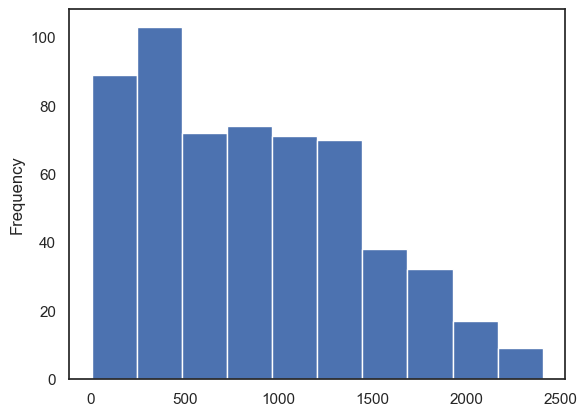

In [188]:
surv_times[(surv_times['weeks_since_hit'] == 1) & (surv_times['burnout_flg_r'])]['spins_to_burnout'].plot(kind='hist')

In [194]:
surv_times[(surv_times['weeks_since_hit'] == 1) & (surv_times['burnout_flg_r'])].sort_values(by=['spins_to_burnout'])

,mediabase_id,call_letters,week_dt,weeks_since_hit,burnout_flg_r,spins_to_burnout,weeks_since_hit_val,song_artist,expected_spins_to_burnout
551461,2570716,KSLZ-FM,2021-05-02,1.0,True,6.0,1,Bang!(AJR),2709.721622
638787,2727194,KHTS-FM,2022-10-30,1.0,True,10.0,1,INDUSTRY BABY(LIL NAS X & JACK HARLOW),1275.864472
549550,2569356,KZZP-FM,2021-03-07,1.0,True,11.0,1,Intentions f/Quavo(JUSTIN BIEBER),1211.758349
590819,2647678,WKST-FM,2021-07-11,1.0,True,12.0,1,Lonely(JUSTIN BIEBER & BENNY BLANCO),2131.702586
571492,2597601,WDCG-FM,2021-04-11,1.0,True,15.0,1,Go Crazy(CHRIS BROWN X YOUNG THUG),2069.333102
...,...,...,...,...,...,...,...,...,...
615416,2693277,KYLD-FM,2021-05-16,1.0,True,2265.0,1,MONTERO (Call Me By Your Name)(LIL NAS X),2516.984087
615734,2693277,WDCG-FM,2021-06-27,1.0,True,2273.0,1,MONTERO (Call Me By Your Name)(LIL NAS X),1607.251984
624746,2708592,WRVW-FM,2021-07-18,1.0,True,2333.0,1,good 4 u(OLIVIA RODRIGO),2249.049516
591620,2650436,KHFI-FM,2021-01-24,1.0,True,2367.0,1,positions(ARIANA GRANDE),1807.870086


In [191]:
surv_times.groupby(['weeks_since_hit', 'burnout_flg_r']).apply(
    lambda x: [len(x), mean_absolute_percentage_error(x['spins_to_burnout'], x['expected_spins_to_burnout'])])

weeks_since_hit  burnout_flg_r
1.0              False             [299, 19.71001702012994]
                 True              [575, 490.0345889157496]
2.0              False            [305, 20.515072548126398]
                 True              [567, 758.4981974778394]
3.0              False             [302, 21.62548445323665]
                                            ...            
49.0             True               [22, 5985.082793977654]
50.0             False             [142, 106.8581625472785]
                 True               [22, 4953.364108754345]
51.0             False            [135, 126.08757421789878]
                 True              [20, 12884.036294252594]
Length: 102, dtype: object

In [190]:
from sklearn.metrics import mean_absolute_error

surv_times.groupby(['weeks_since_hit', 'burnout_flg_r']).apply(
    lambda x: mean_absolute_error(x['spins_to_burnout'], x['expected_spins_to_burnout']))

weeks_since_hit  burnout_flg_r
1.0              False             500.550336
                 True              753.418619
2.0              False             519.143644
                 True              777.471817
3.0              False             544.199893
                                     ...     
49.0             True             1877.764698
50.0             False             392.307364
                 True             1868.129164
51.0             False             386.937061
                 True             1890.681789
Length: 102, dtype: float64

In [ ]:
surv_times[surv_times['call_letters'] == 'KIIS-FM']

In [ ]:
mask_demo_1 = (surv_times['mediabase_id'] == 2591406) & (surv_times['call_letters'] == 'WKST-FM')
surv_time_demo_1 = surv_times[mask_demo_1]
surv_time_demo_1[surv_time_demo_1['expected_spins_to_burnout'] < 0] = np.nan
surv_time_demo_1[np.isinf(surv_time_demo_1['expected_spins_to_burnout'])] = np.nan

In [ ]:
mask_demo_2 = (surv_times['call_letters'] == 'KIIS-FM') & (surv_times['mediabase_id'] == 2583267)
surv_time_demo_2 = surv_times[mask_demo_2]
surv_time_demo_2[surv_time_demo_2['expected_spins_to_burnout'] < 0] = np.nan
surv_time_demo_2[np.isinf(surv_time_demo_2['expected_spins_to_burnout'])] = np.nan

In [ ]:
mask_demo_3 = (surv_times['call_letters'] == 'WHTZ-FM') & (surv_times['mediabase_id'] == 2582475)
surv_time_demo_3 = surv_times[mask_demo_3]
surv_time_demo_3[surv_time_demo_3['expected_spins_to_burnout'] < 0] = np.nan
surv_time_demo_3[np.isinf(surv_time_demo_3['expected_spins_to_burnout'])] = np.nan

In [ ]:
plt.plot(surv_time_demo_1['weeks_since_hit'], surv_time_demo_1['expected_spins_to_burnout'])
plt.plot(surv_time_demo_1['weeks_since_hit'], surv_time_demo_1['spins_to_burnout'])
plt.title(pd.unique(surv_time_demo_1['song_artist'])[0] + ' at ' + pd.unique(surv_time_demo_1['call_letters'])[0])
plt.xlabel('weeks since hit')
plt.ylabel('spins to burnout')
plt.tight_layout()
plt.savefig('demo1.jpeg', format='jpeg', dpi=300)

In [ ]:
plt.plot(surv_time_demo_2['weeks_since_hit'], surv_time_demo_2['expected_spins_to_burnout'])
plt.plot(surv_time_demo_2['weeks_since_hit'], surv_time_demo_2['spins_to_burnout'])
plt.title(pd.unique(surv_time_demo_2['song_artist'])[0] + ' at ' + pd.unique(surv_time_demo_2['call_letters'])[0])

In [ ]:
plt.plot(surv_time_demo_3['weeks_since_hit'], surv_time_demo_3['expected_spins_to_burnout'])
plt.plot(surv_time_demo_3['weeks_since_hit'], surv_time_demo_3['spins_to_burnout'])
plt.title(pd.unique(surv_time_demo_3['song_artist'])[0] + ' at ' + pd.unique(surv_time_demo_3['call_letters'])[0])
plt.xlabel('weeks since hit')
plt.ylabel('spins to burnout')
plt.tight_layout()
plt.savefig('demo3.jpeg', format='jpeg', dpi=300)

#### Create a baseline model

In [ ]:
# df_base_train

In [ ]:
# X_train = pd.get_dummies(df_base_train[X_cols], columns=['market_name'])

In [ ]:
# X_num_cols = list(set(X_cols) - set(['market_name']))

In [ ]:
# scaler = StandardScaler()
# scaler_fit = scaler.fit(X_train[X_num_cols])

In [ ]:
# X_train[X_num_cols] = scaler.fit_transform(X_train[X_num_cols])

In [ ]:
# X_train

#### Linear Model

In [ ]:
# cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, fit_baseline_model=True)
# cox_elastic_net.fit(X_train, df_base_train[y_cols].to_records(index=False))

In [ ]:
# cox_elastic_net.score(X_train, df_base_train[y_cols].to_records(index=False))

In [ ]:
# cox_elastic_net.deviance_ratio_

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=pd.get_dummies(df_base_train[X_cols], columns=['market_name']).columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=10)

In [ ]:
# import warnings
# from sklearn.exceptions import FitFailedWarning
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
#
# coxnet_pipe = make_pipeline(
#     StandardScaler(),
#     CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.00001, max_iter=1000)
# )
# warnings.simplefilter("ignore", UserWarning)
# warnings.simplefilter("ignore", FitFailedWarning)
# coxnet_pipe.fit(X_train, df_base_train[y_cols].to_records(index=False))

In [ ]:
# estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
# cv = KFold(n_splits=5, shuffle=True, random_state=0)
# gcv = GridSearchCV(
#     make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
#     param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
#     cv=cv,
#     error_score=0.5,
#     n_jobs=1).fit(X_train, df_base_train[y_cols].to_records(index=False))
#
# cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
# alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
# mean = cv_results.mean_test_score
# std = cv_results.std_test_score
#
# fig, ax = plt.subplots(figsize=(9, 6))
# ax.plot(alphas, mean)
# ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
# ax.set_xscale("log")
# ax.set_ylabel("concordance index")
# ax.set_xlabel("alpha")
# ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
# ax.grid(True)

#### RandomForest Model

In [ ]:
# random_state=20
# rsf = RandomSurvivalForest(n_estimators=100,
#                            min_samples_split=10,
#                            min_samples_leaf=10,
#                            n_jobs=-1,
#                            random_state=random_state)
# rsf.fit(X_train, df_base_train[y_cols].to_records(index=False))

In [ ]:
# rsf.score(X_train, df_base_train[y_cols].to_records(index=False))

In [ ]:
# plt.step(cox_elastic_net.predict_survival_function(X_train)[5].x, cox_elastic_net.predict_survival_function(X_train)[5].y)  d